## Compute RVEDA, RVESA

- RV areas should be measured from the apical four-chamber view.
- Note: Two-dimensional echocardiographic image acquisition should aim to maximize RV area

- Measurements and feature names:
    - RVEDA - Right ventricle end diastolic area
    - RVESA - Right ventricle end systolic area

- For general reference, 2D echocardiographic 
    - RV EDAs of 13 cm<sup>2</sup> for men and 12 cm<sup>2</sup> for women should be used as the upper limits of the corresponding normal range.
    - RV ESAs of 8 cm<sup>2</sup> for men and 7 cm<sup>2</sup> for women should be used as the upper limits of the corresponding normal range.
    


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.stats import mannwhitneyu
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

from utils import stats_and_plots, measurements_dict, BA_plot

In [2]:
def get_dataCat(df,feature1, value):
    """
    transform feature value in categorical
    Input: 
        - dataframe 
        - feature to be categorized. E.g., LAVI_echo_cat, LAV_echo, LAV_model LVMI_echo_cat, LVEF_echo, etc.
        - value to use as normal - Use 0 for RAVI, and RV, 35 for LVEF, normal for others
    """

    df_BA = df.copy()
    if feature1 == 'LVEF_echo':
        df_BA[feature1][df_BA[feature1] > value] = 'Normal' 
    else:
        df_BA[feature1][df_BA[feature1] == value] = 'Normal' 

    df_BA[feature1][df_BA[feature1] != 'Normal'] = 'Abnormal'
    return df_BA[feature1]

## Load Numbers table

In [3]:
### Load Clinical Echo Measurements
df_numbers = pd.read_csv('test_data/RV_area/RV_area.csv')
df_numbers

,anonid,Pt. Sex,BSA,RVEDA_echo,RVESA_echo
0,RVTEST01,F,2.025729,21.632979,11.459833
1,RVTEST02,F,1.599975,11.007861,7.155092
2,RVTEST03,M,1.771676,16.689544,8.606150
3,RVTEST04,M,2.089853,15.328141,8.710965
4,RVTEST05,F,1.746207,24.786972,18.535510
5,RVTEST06,M,1.684941,15.980915,6.917082
6,RVTEST07,M,2.151507,23.009388,10.718564
7,RVTEST08,F,1.712470,21.738561,12.431616
8,RVTEST09,F,1.991369,17.176244,9.360185
9,RVTEST10,M,2.068421,16.753408,9.737379


## Load dataframes with RV measurements

In [4]:
df_a4c_allFrames = pd.read_csv('test_data/RV_area/A4C_measures_R2.csv')
df_a4c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0
mean,28.896104,113.259740,97.259740,184.623377,139.636364,12.762293,12.762293,14.003922,151.116883,117.311688,...,117.038961,0.258142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,9.183200,54.762742,26.326094,30.666731,30.046853,7.715665,7.715665,8.576117,38.557194,26.659283,...,27.028952,0.123607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,21.000000,31.000000,48.000000,116.000000,58.000000,0.030518,0.030518,0.030518,75.000000,55.000000,...,55.000000,0.003720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,22.000000,62.000000,77.000000,160.000000,113.000000,5.975342,5.975342,6.445312,118.000000,95.000000,...,96.000000,0.141173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,23.000000,114.000000,95.000000,187.000000,142.000000,12.390137,12.390137,13.513184,148.000000,118.000000,...,121.000000,0.278024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,35.000000,159.000000,115.000000,212.000000,167.000000,18.530273,18.530273,19.891357,188.000000,137.000000,...,134.000000,0.362699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,48.000000,213.000000,164.000000,232.000000,196.000000,30.975342,30.975342,35.919189,215.000000,170.000000,...,174.000000,0.472177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Apply qc rules

In [5]:
# Select the RV labels
df_a4c_RV = df_a4c_allFrames[df_a4c_allFrames['label'] == 'RV']

# Select the clips which fit the sinusoidal model best
df_a4c_RV.sort_values(by=['Rsquared'], ascending=False).drop_duplicates(subset=['anonid'], keep='first', inplace=True)

# Select the diastolic frames (largest area)
df_a4c_dia = df_a4c_RV.sort_values(by=['area'], ascending=False).drop_duplicates(subset=['ID_clip'])

# Select the systolic frames (smallest area)
df_a4c_sys = df_a4c_RV.sort_values(by=['area'], ascending=True).drop_duplicates(subset=['ID_clip'])

## Merge the data

In [6]:
# Merge the diastolic and systolic frames
df_a4c_all = df_a4c_dia.merge(df_a4c_sys, on=['anonid', 'ID_clip'], suffixes=('_dia', '_sys'))

# Merge the clinical data with the RV area data
df_all = df_a4c_all.merge(df_numbers,on=['anonid'],how='inner')

print(f'anonid:{len(df_all.anonid.unique())}, merged:{df_all.shape[0]}, merged anonid:{len(df_all.anonid.unique())}')

anonid:10, merged:10, merged anonid:10


In [7]:
# Rename the area columns
df_vol = df_all.copy()
df_vol.rename(columns={'area_sys': 'RVESA_model', 'area_dia': 'RVEDA_model'}, inplace=True)

## Bin RV area in normal and abnormal

In [8]:
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Cat values for Model Pred
df_vol['RVEDA_model_cat'] = df_vol['RVEDA_model'].astype(int)
df_vol['RVEDA_model_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['RVEDA_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rveda_echo_male_dict)), df_vol['RVEDA_model_cat'])
df_vol['RVEDA_model_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['RVEDA_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rveda_echo_female_dict)), df_vol['RVEDA_model_cat'])

## Cat values for Numbers table 
df_vol['RVEDA_echo_cat'] = df_vol['RVEDA_echo'].astype(int)
df_vol['RVEDA_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['RVEDA_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rveda_echo_male_dict)), df_vol['RVEDA_echo_cat'])
df_vol['RVEDA_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['RVEDA_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rveda_echo_female_dict)), df_vol['RVEDA_echo_cat'])

## Cat values for Model Pred
df_vol['RVESA_model_cat'] = df_vol['RVESA_model'].astype(int)
df_vol['RVESA_model_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['RVESA_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rvesa_echo_male_dict)), df_vol['RVESA_model_cat'])
df_vol['RVESA_model_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['RVESA_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rvesa_echo_female_dict)), df_vol['RVESA_model_cat'])

## Cat values for Numbers table 
df_vol['RVESA_echo_cat'] = df_vol['RVESA_echo'].astype(int)
df_vol['RVESA_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['RVESA_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rvesa_echo_male_dict)), df_vol['RVESA_echo_cat'])
df_vol['RVESA_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['RVESA_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.rvesa_echo_female_dict)), df_vol['RVESA_echo_cat'])

## Compute and plot some metrics

Area - Right Ventricle 
(10, 82)


,RVEDA_echo,RVEDA_model,RVESA_echo,RVESA_model
mean,18.410401,19.000244,10.363238,10.676270
std,4.225629,3.845119,3.362809,2.472802
min,11.007861,14.819336,6.917082,5.578613
max,24.786972,28.771973,18.535510,13.702393


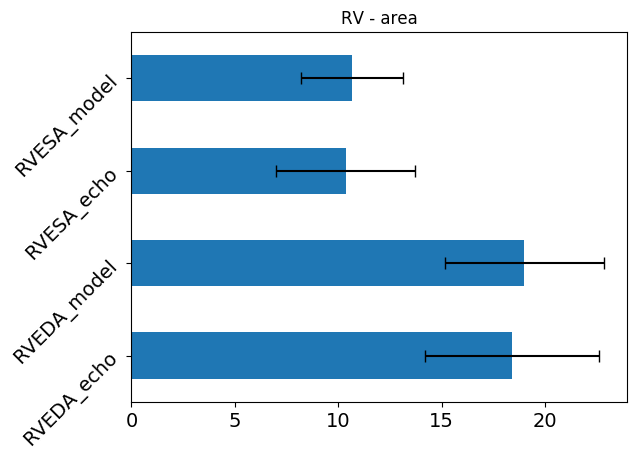

In [9]:
## Mean, std and range of volume.
print('Area - Right Ventricle ')
print(df_vol.shape)
df_vol_stats  = df_vol[['RVEDA_echo', 'RVEDA_model', 'RVESA_echo', 'RVESA_model']].agg(['mean','std','min', 'max'])
display(df_vol_stats)


df_vol_stats.T.plot(kind = "barh", y = ["mean"], legend = False,
            title = 'RV - area',fontsize=14,  xerr='std', capsize=4,rot=45)
plt.show()

## Regression and Bland-Altman Plots


10


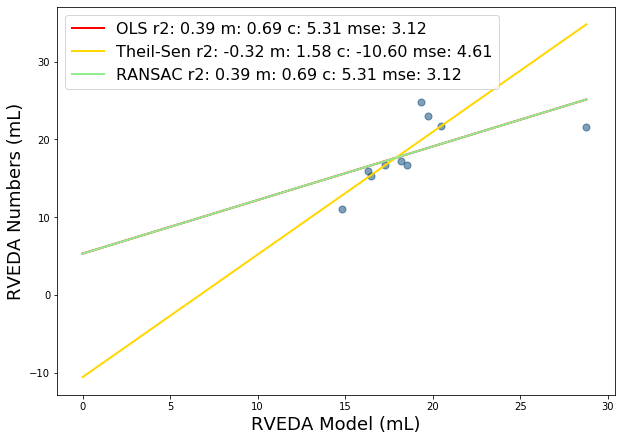

['Normal', 'Abnormal']
['Abnormal' 'Normal']


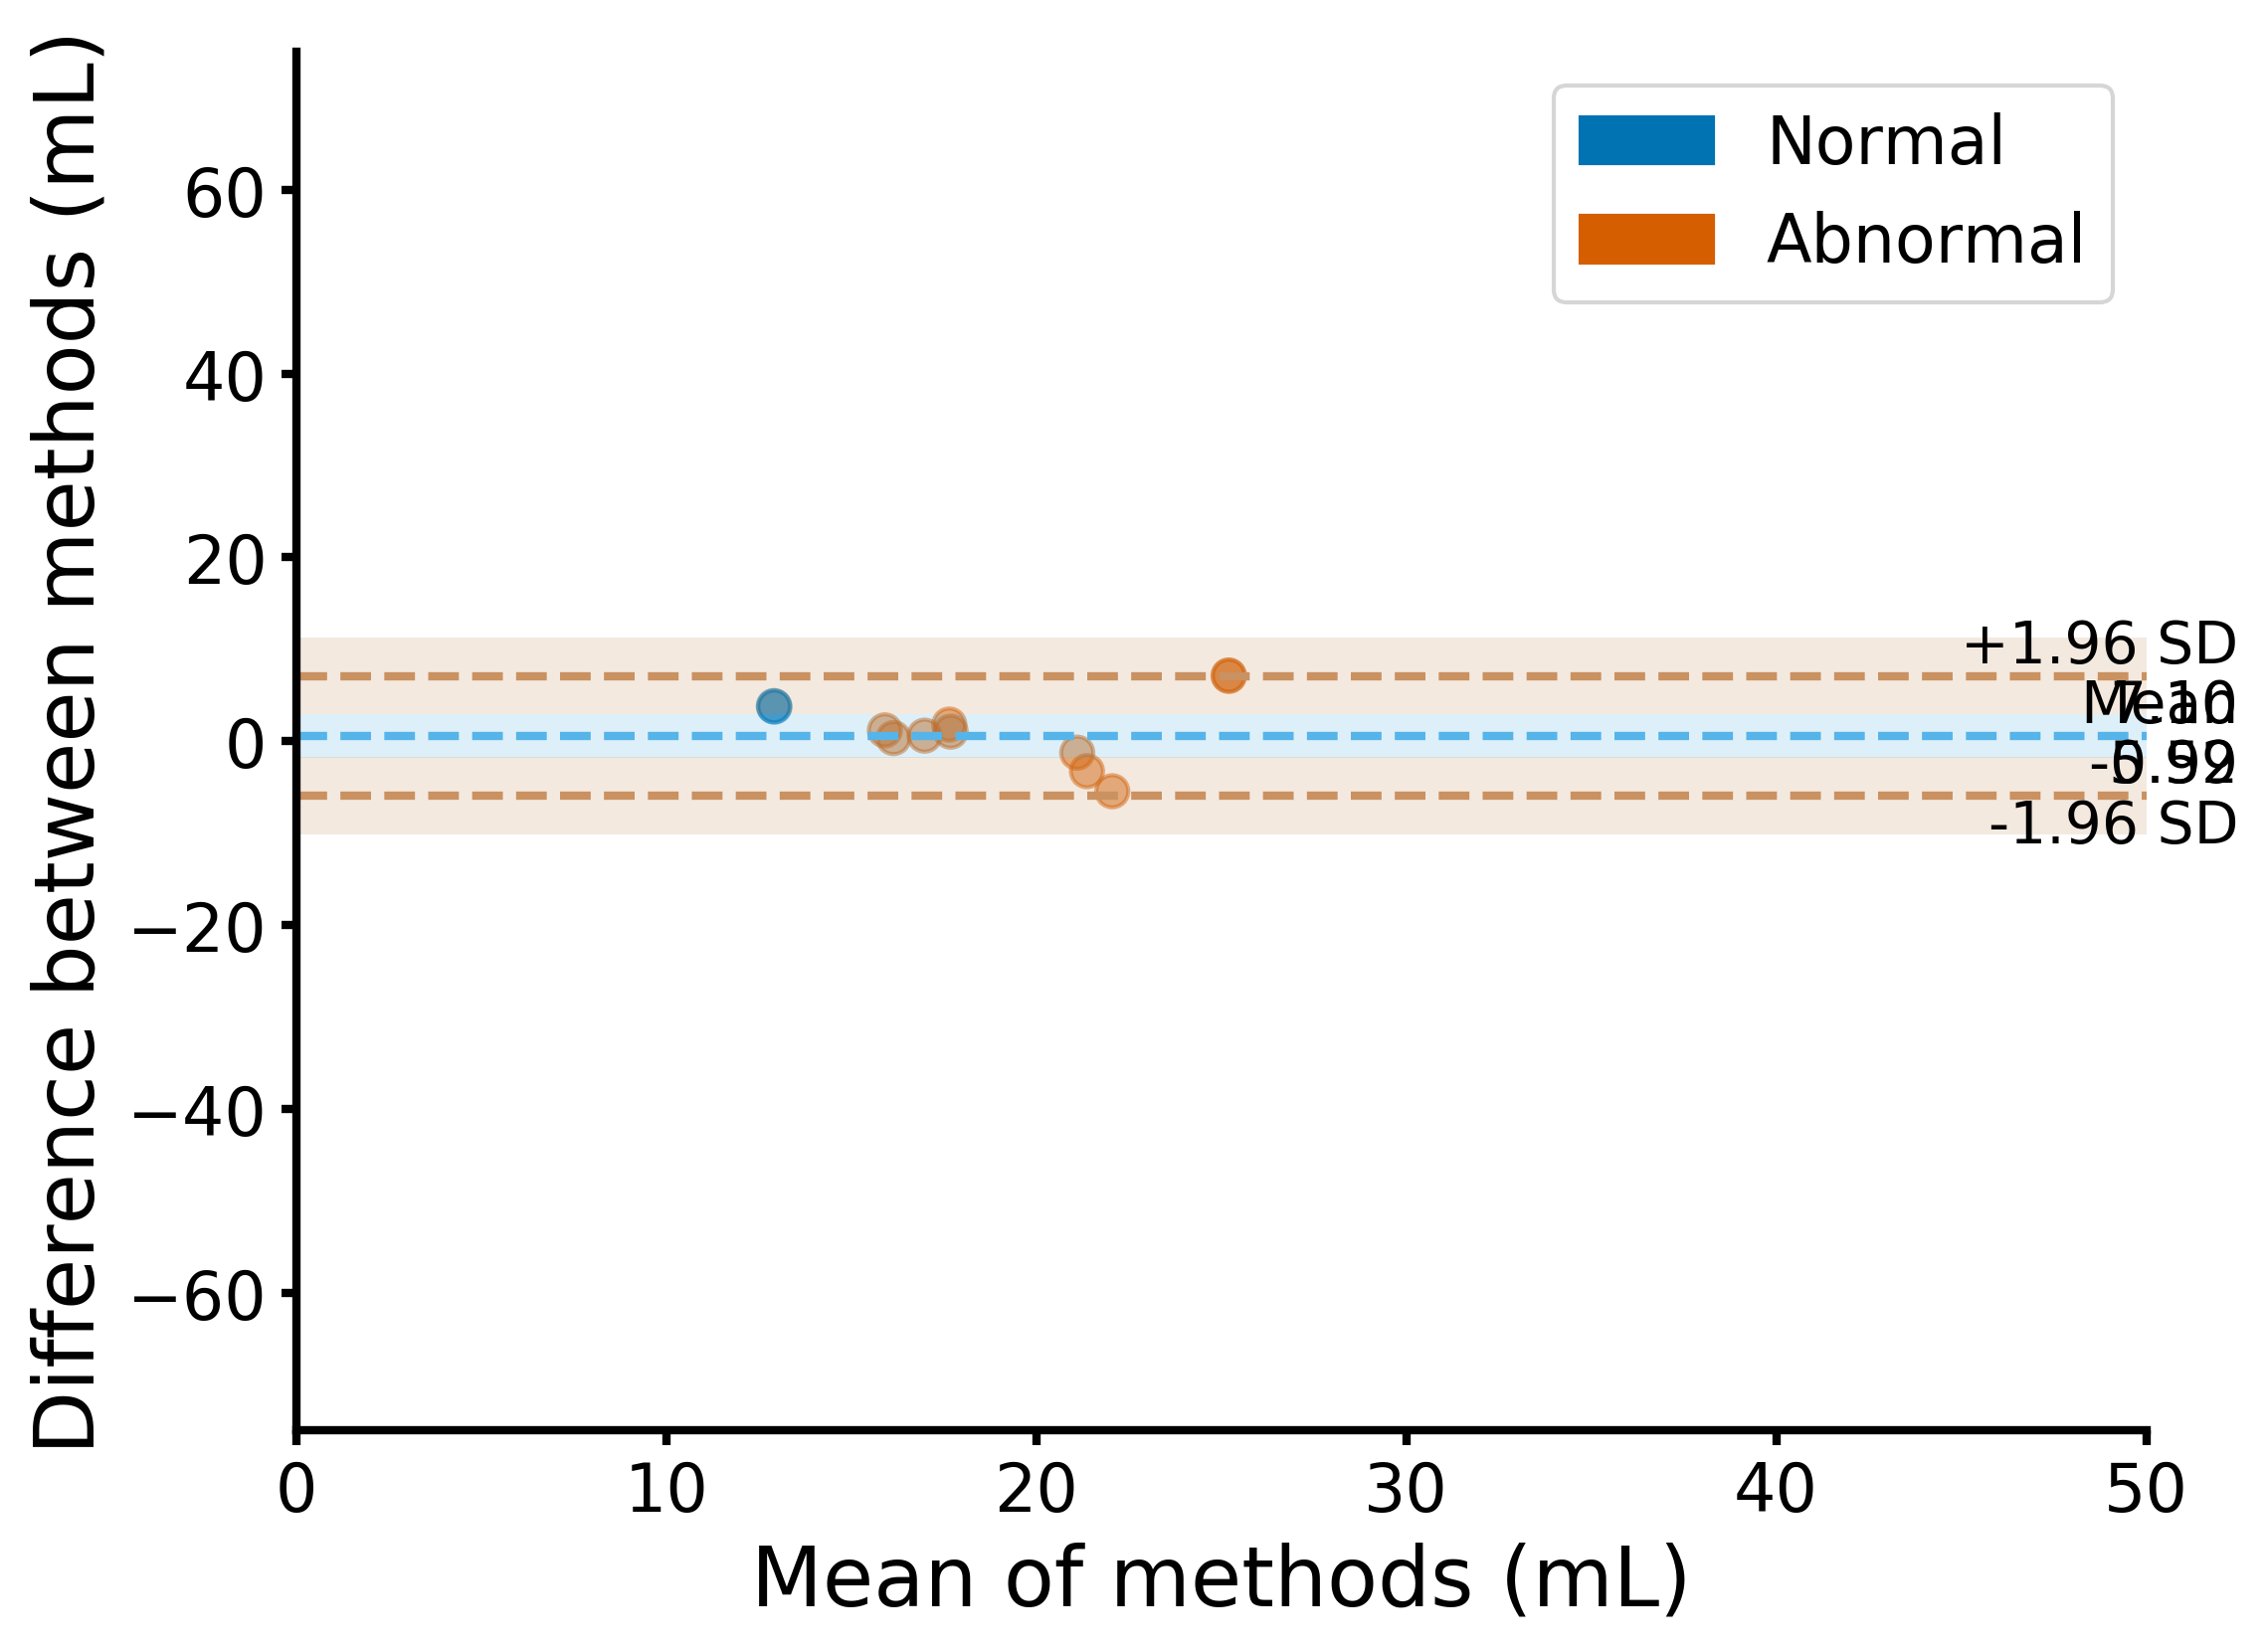

SpearmanrResult(correlation=0.8545454545454544, pvalue=0.0016368033159867143)
MWU p-value: MannwhitneyuResult(statistic=47.0, pvalue=0.42505336956926293)
10


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


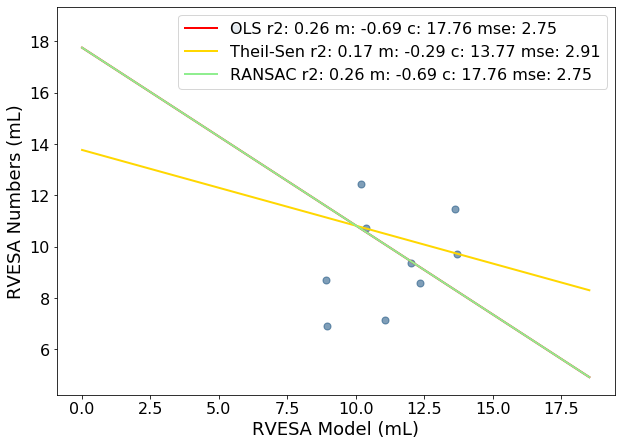

['Normal', 'Abnormal']
['Abnormal' 'Normal']


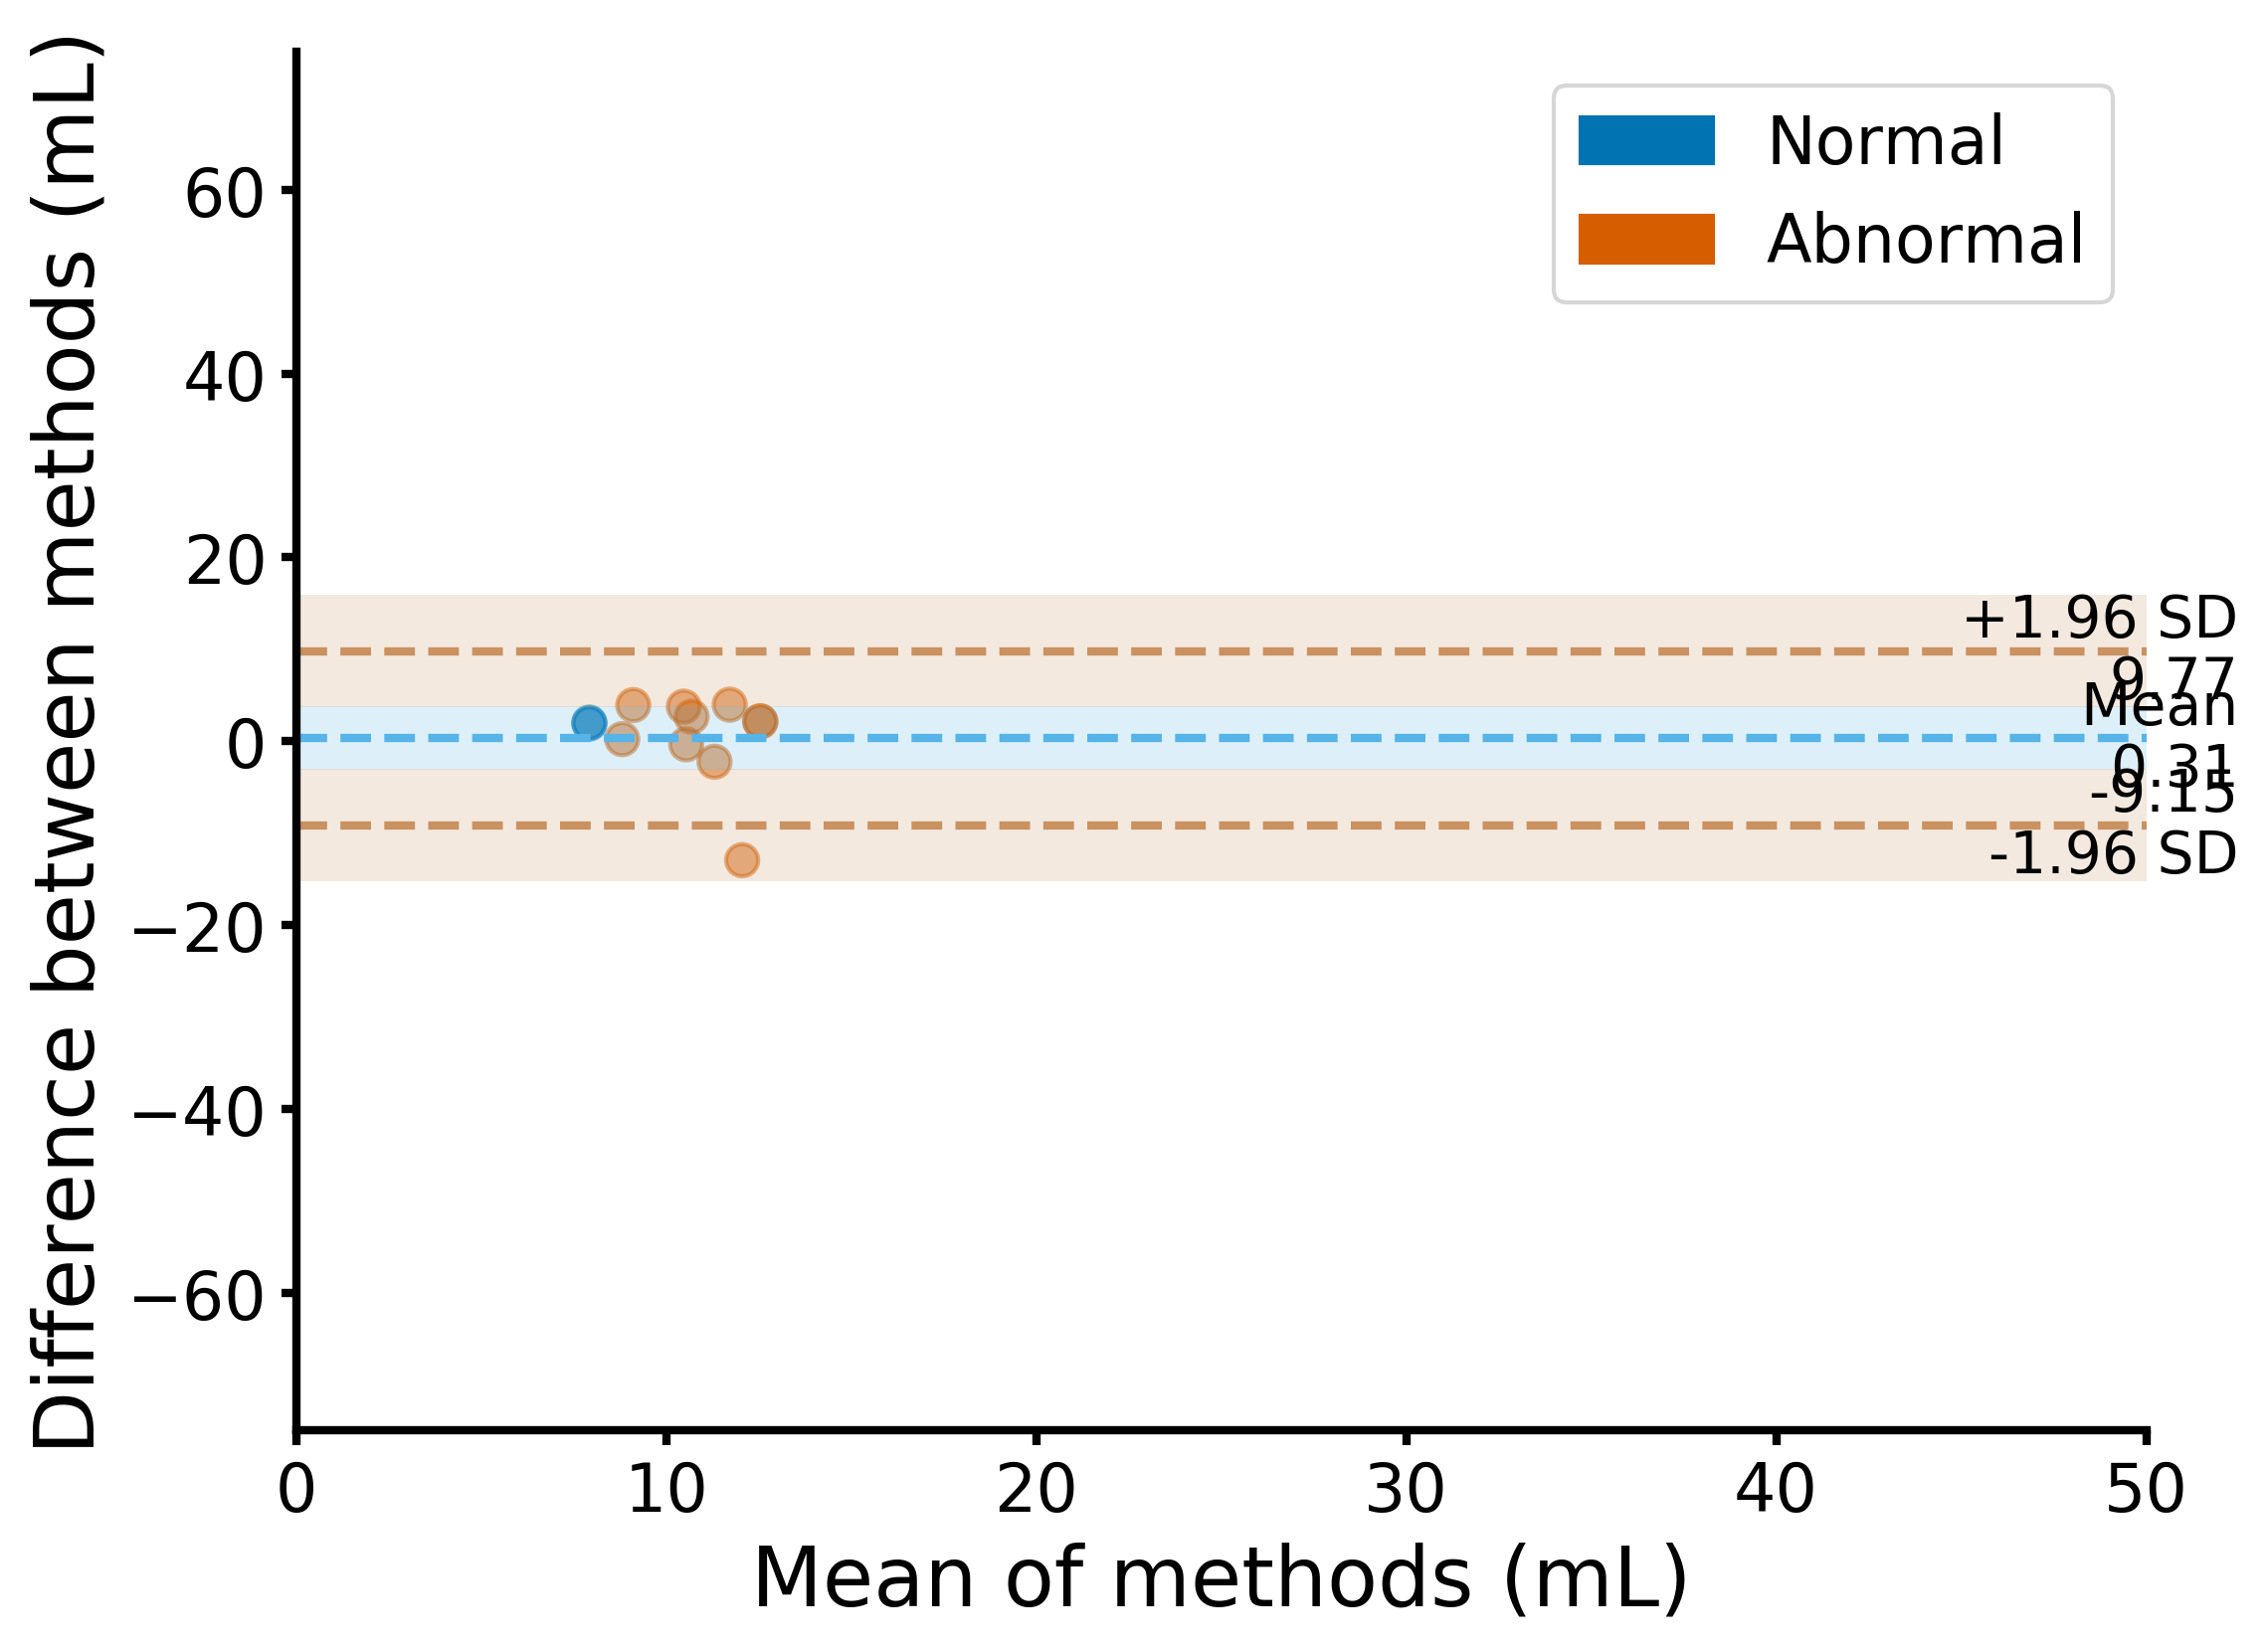

SpearmanrResult(correlation=-0.09090909090909088, pvalue=0.8027717312071619)
MWU p-value: MannwhitneyuResult(statistic=39.0, pvalue=0.21367765694890384)


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [10]:
############ RVEDA ##################

df_plot = df_vol

ys = df_plot['RVEDA_echo']
xs = df_plot['RVEDA_model']
print(len(xs))
stats_and_plots.get_reg_plot(xs, ys,'Numbers-Model', 'RVEDA Model', 'RVEDA Numbers', 'mL')

dataCat = df_plot.RVEDA_echo_cat
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
                    loaColour='#ca9161', pointColour='#0173b2',lim_inf=-75, lim_sup=75, lim_inf_x=0,
                    lim_sup_x=50, cat=True, unity='mL')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

############ RVESA ##################

df_plot = df_vol

ys = df_plot['RVESA_echo']
xs = df_plot['RVESA_model']
print(len(xs))
stats_and_plots.get_reg_plot(xs, ys,'Numbers-Model', 'RVESA Model', 'RVESA Numbers', 'mL')

dataCat = df_plot.RVESA_echo_cat
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
                    loaColour='#ca9161', pointColour='#0173b2',lim_inf=-75, lim_sup=75, lim_inf_x=0,
                    lim_sup_x=50, cat=True, unity='mL')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

## Plot Confusion Matrix

Confusion Matrix - Numbers vs Unet


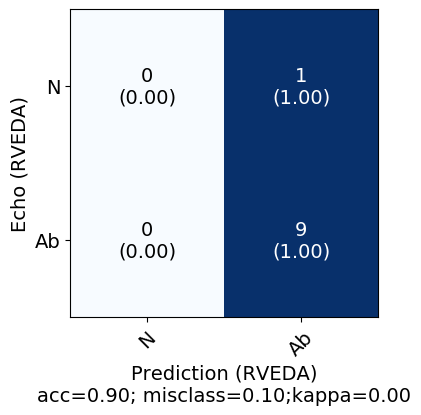

Confusion Matrix - Numbers vs Unet


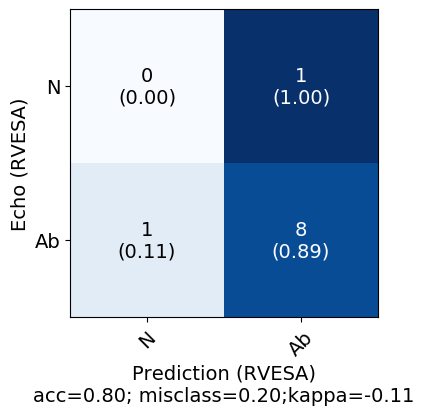

In [11]:
############### RVEDA ##################

plt.rcParams.update({'font.size': 14})


y_true = df_vol['RVEDA_echo_cat'] == 'Abnormal'
y_pred = df_vol['RVEDA_model_cat'] == 'Abnormal'

cm = confusion_matrix(y_true, y_pred) #.ravel()

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (RVEDA)')
plt.xlabel('Prediction (RVEDA)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()


############### RVESA ##################

plt.rcParams.update({'font.size': 14})


y_true = df_vol['RVESA_echo_cat'] == 'Abnormal'
y_pred = df_vol['RVESA_model_cat'] == 'Abnormal'

cm = confusion_matrix(y_true, y_pred) #.ravel()

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (RVESA)')
plt.xlabel('Prediction (RVESA)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()